# Using random forest to predict populations at risk of obesity

# Executive Summary

This project explores the use of Random Forest (RF) to identify cohorts at risk of obesity based on lifestyle and behavioural factors. This project uses publicly available data to serve as a proof of concept for predictive modelling in addressing the real business challenge of obesity costs within the NHS and wider public sector whilst aligning with prevention priorities for the NHS and the Bury Locality. 

RF was selected due to the nature of the data provided and for interpretability through feature importance. Key results include a recall of 84%, potential for generalisation and the ability to use model outputs for decision making. Visualisations such as a feature importance chart were employed to support interpretability. 

Recommendations include future iterations using local data, including SHAP analysis for further interpretability and targeting, and further cost-benefit analysis. This project provides a strong case study for data-driven, prevention-focused predictive modelling within the Bury Locality. 

# Project Background

It is well documented that obesity can lead to serious health conditions (NHS, 2017) and costs the NHS around £6.5 billion per year (DHSC, 2023). Lord Darzi’s (Darzi, 2024) independent review of the NHS emphasised the need for Integrated Care Boards (ICB) to shift from reactive hospital care to preventative community care. In line with this, Bury Locality, as part of Greater Manchester Integrated Care Partnership, has established a major conditions board (‘Bury Integrated Care Partnership Locality Plan Refreshed for 2025/2026’, no date) to identify key issues, risks and gaps. 

This project supports that ambition by exploring the use of RF in identifying populations at higher risk of obesity based on demographic and behavioural factors. Such models could enable the Locality to target preventative interventions more effectively – ultimately improving health outcomes and achieving greater financial efficiency. 

# Methodology

To test this approach, publicly available data from a study on obesity (Koklu, N., & Sulak, S.A., 2024) has been sought, via Kaggle, to develop a proof of concept. Whilst the dataset is not UK-based, it provides an opportunity to assess the feasibility of RF in identifying at-risk populations. The insights gained from this analysis will inform the potential application of similar models using local data.

RF has been chosen due to it’s ability to handle mixed data types, non-linear relationships, imbalanced data, correlated variables and has shown to have better predictive performance than other classification models (Breiman, 2001). Feature importance is also a factor in RF that is useful to decision makers in resource targeting decisions.

# Data Infrasrtucture & Tools

The dataset includes demographic and behavioural factors and the variable coding was provided by the study authors.

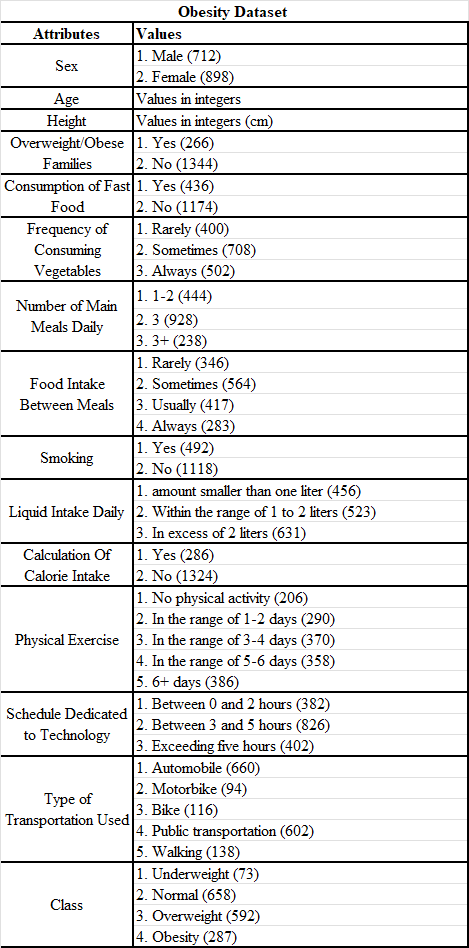

The data comes in an Excel spreadsheet format downloaded from Kaggle (https://www.kaggle.com/datasets/suleymansulak/obesity-dataset/data). 

The project was developed locally in Jupyter Notebooks but, should this lead to the development of projects using NHS data, the organisation’s cloud-based infrastructure, Snowflake, could be used to ensure the most recent data is used and is suitably secured. Snowflake includes Python integration and so code could be recreated in that environment. 

Libraries used in Python included pandas for data manipulation, scikit-learn for modelling, numpy for maths and matplotlib and seaborn for data visualisation. These libraries are well established and well-used for these purposes.

In [ ]:
## Import the libraries relevant to this project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import randint

The data was pulled into a pandas dataframe for exploration and manipulation.

In [ ]:
## load data into a Pandas dataframe

df_obesity = pd.read_excel('Obesity_Dataset.xlsx')
df_obesity.head()

# Data Engineering

Checks were carried out for duplicate and null values. 

In [ ]:
## Basic exploration to understand data quality

df_obesity.describe()

In [ ]:
## Check for any null values

df_obesity.info()

In [ ]:
## Check for any duplicate values

df_obesity.duplicated()

“For users (decision makers, analysts, experts, project stakeholder, etc), the interpretability of ML models is often as important as their predictive performance” (Haddouchi and Berrado, 2024). It is for this reason that, though it was not necessary to create bins for the Age and Height variables because RF splits the data at the optimal threshold when creating each tree, interpretability was prioritised because this project is a use-case for using predictive models in health care commissioning decision making and interventions are likely to be targeted at population groups, rather than people of individual ages and heights. After binning, the original Age and Height fields were dropped from the dataframe.

In [ ]:
## Create bins for height and age fields

bins_h = [149, 159, 169, 179, 193]
labels_h = ['150-159', '160-169', '170-179', '180-193']

df_obesity['Height_Group'] = pd.cut(df_obesity['Height'], bins=bins_h, labels=labels_h, right=True)


bins_a = [17, 24, 34, 44, 54]
labels_a = ['18-24', '25-34', '35-44', '45-54']

df_obesity['Age_Group'] = pd.cut(df_obesity['Age'], bins=bins_a, labels=labels_a, right=True)

df_obesity.head()

In [ ]:
## Drop existing height and age fields

df_obesity=df_obesity.drop(columns=['Age', 'Height'])

In [ ]:
df_obesity.head()

According to Pinheiro et al, RF is not sensitive to scale so scaling of the data was not required (Pinheiro et al., 2025). If an alternative model, such as logistic regression, was used then the data would be normalised because that model is sensitive to scale. 

Outcome data was found to be unbalanced, therefore the decision was made to apply class weighting to ensure the model didn’t simply favour the majority classes.

In [ ]:
## Looking to see whether the data is unbalanced

sns.countplot(data=df_obesity,x='Class')

Data was split the data into X and Y variables and encoded because, although integers are used to represent values, they are not binary.  

In [ ]:
## Splitting the data into x and y variables and retaining class names for interpretability

X = df_obesity.drop('Class', axis=1)
y = df_obesity['Class'] -1
class_names = ['Underweight', 'Normal', 'Overweight', 'Obesity']

In [ ]:
## Convert fields to string so they can be encoded
X_str = X.select_dtypes(include='int').columns
X[X_str] = X[X_str].astype(str)

## Encode the data
X = pd.get_dummies(X)

X.head()

Finally, the data was split into train and test sets with an 80%/20% split.

In [ ]:
## 80/20 split of data into training and testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Data Analytics

The data was checked for the best hyperparameters to use in RF and those hyperparameters applied to produce the best model. 

According to (Rimal, Y., Sharma, N., Paudel, S. et al., 2025) “Cross-validation is a robust statistical approach to evaluating machine learning models by systematically splitting data into training and testing subsets. This method ensures models generalize effectively to unseen data, minimizing the risks of overfitting and underfitting.” and so cross-validation was included in the analysis.

In [ ]:
## Random Forest with hyperparameter tuning
param_dist = {'n_estimators': randint(50, 500), 'max_depth': randint(1, 20)}
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rand_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=5, cv=5, random_state=42)
rand_search.fit(X_train, y_train)
best_rf = rand_search.best_estimator_

In [ ]:
## Using the best Random Forest model to predict, create evaluation metrics and carry out cross-validation
y_pred_rf = best_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, average='weighted')
rec_rf = recall_score(y_test, y_pred_rf, average='weighted')
cv_scores_rf = cross_val_score(best_rf, X, y, cv=5)

Gradient Boosting (GB) is an alternative model to RF (Natekin and Knoll, 2013). To ensure the best model was used for the project, a GB model was also produced to compare against RF.

In [ ]:
## Additional model for comparision: Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
acc_gb = accuracy_score(y_test, y_pred_gb)
prec_gb = precision_score(y_test, y_pred_gb, average='weighted')
rec_gb = recall_score(y_test, y_pred_gb, average='weighted')
cv_scores_gb = cross_val_score(gb, X, y, cv=5)

Confusion matrices were produced for both models and feature importance calculated.

In [ ]:
## Creating confusion matrices of both models
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_gb = confusion_matrix(y_test, y_pred_gb)

In [ ]:
## Calculating feature importance to the model
feature_importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
top_features = feature_importances.head(20)

In [ ]:
## Create the visualisations for importance and model evaluation
plt.figure(figsize=(10, 6))
top_features.plot.bar()
plt.title("Top 20 Feature Importances (Random Forest)")
plt.tight_layout()
plt.savefig("feature_importance_rf.png")
plt.show()

ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=class_names).plot()
plt.title("Confusion Matrix with class labels - Random Forest")
plt.savefig("confusion_matrix_rf.png")
plt.show()

ConfusionMatrixDisplay(confusion_matrix=cm_gb, display_labels=class_names).plot()
plt.title("Confusion Matrix with class labels - Gradient Boosting")
plt.savefig("confusion_matrix_gb.png")
plt.show()

# Results

Recall is the most important metric to this project as the cost to the NHS of missing a patient to offer health advice is more than providing advice to those who might not need it. 

In [ ]:
## Print model evaluation metrics for both RF and GB for comparison
print("Random Forest:")
print("Accuracy:", acc_rf)
print("Precision:", prec_rf)
print("Recall:", rec_rf)
print("CV Accuracy Scores:", cv_scores_rf)
print("Mean CV Accuracy:", np.mean(cv_scores_rf))

print("\nGradient Boosting:")
print("Accuracy:", acc_gb)
print("Precision:", prec_gb)
print("Recall:", rec_gb)
print("CV Accuracy Scores:", cv_scores_gb)
print("Mean CV Accuracy:", np.mean(cv_scores_gb))

Recall for RF was 84% which means the model is performing well. The high CV accuracy scores indicate that the model would generalise well and RF outperformed Gradient Boosting on all evaluation metrics. 

The confusion matrices indicate that RF predicted the class closer to the true class than GB. For example, GB incorrectly predicted 3 obese individuals as normal whilst RF predicted only one. 
Feature importance analysis revealed that the most important features were:

•	Physical exercise – no physical activity

•	Frequency of vegetable consumption - always

•	Number of main meals daily – 3+

# Data Visualisation and Dashboards

To aid in communicating findings from the model, visualisations for feature importance and confusion matrices were created. Decision makers come from a variety of backgrounds but many would not know how to interpret a confusion matrix therefore they were created with the original class labels included to aid in interpretation by non-technical audiences.

Feature importance visualisation is particularly useful to decision makers as these help to prioritise interventions based on lifestyle factors. Future iterations could include interactive dashboards for decision makers to explore the data in more detail, particularly if future iterations include demographic information so end-users can explore the most important features for different cohorts. 

# Impact and Conclusions

The model demonstrates strong predictive capability in identifying individuals at risk of obesity. Its generalisability to new data suggests a similar model could have application in a real-world setting and directly inform intervention planning. 

Nudge theory suggests behaviour change intervention is most effective at a change in life stage (Behavioural Insights Team, 2024). Health visitors could use these results to advise parents of new school starters about the benefits of active travel in reducing obesity risk. A cost-benefit analysis of planned interventions would strengthen decision making.

Whilst this project provides a strong use-case for predictive modelling in targeting preventative NHS interventions, the data is not local and therefore will contain bias towards the population it was collected from. 

Future iterations of the model could use a binary outcome instead of multi-class (e.g., overweight/obese vs not) to improve predictive power and interpretability. SHAP analysis could explains feature contributions to individual predictions (Kim and Kim, 2022). Deprivation or poverty indicators would support segmentation of people within interactive dashboards to assess health inequalities and support the Locality’s strategic focus in this area. 

# References

Behavioural Insights Team (2024) ‘EAST: Four Simple Ways to Apply Behavioural Insights’, BIT, 16 December. Available at: https://www.bi.team/publications/east-four-simple-ways-to-apply-behavioural-insights/ (Accessed: 7 July 2025).

Breiman, L. (2001) ‘Random Forests’, Machine Learning, 45(1), pp. 5–32. Available at: https://doi.org/10.1023/A:1010933404324.

‘Bury Integrated Care Partnership Locality Plan Refreshed for 2025/2026’ (no date). Available at: https://councildecisions.bury.gov.uk/documents/s43774/finalv13%20locality%20plan%20refresh%202526%20draft%2014.03.25%20vWB.pdf (Accessed: 30 June 2025).

Darzi, A. (2024) ‘Independent Investigation of the National Health Service in England’. UK Government. Available at: https://assets.publishing.service.gov.uk/media/66f42ae630536cb92748271f/Lord-Darzi-Independent-Investigation-of-the-National-Health-Service-in-England-Updated-25-September.pdf (Accessed: 30 June 2025).

DHSC (2023) ‘Government plans to tackle obesity in England – Department of Health and Social Care Media Centre’, 7 June. Available at: https://healthmedia.blog.gov.uk/2023/06/07/government-plans-to-tackle-obesity-in-england/ (Accessed: 30 June 2025).

Haddouchi, M. and Berrado, A. (2024) ‘A survey and taxonomy of methods interpreting random forest models’. arXiv. Available at: https://doi.org/10.48550/arXiv.2407.12759.

Kim, Yesuel and Kim, Youngchul (2022) ‘Explainable heat-related mortality with random forest and SHapley Additive exPlanations (SHAP) models’, Sustainable Cities and Society, 79, p. 103677. Available at: https://doi.org/10.1016/j.scs.2022.103677.

Koklu, N., & Sulak, S.A. (2024) Obesity Dataset. Available at: https://www.kaggle.com/datasets/suleymansulak/obesity-dataset (Accessed: 30 June 2025).

Natekin, A. and Knoll, A. (2013) ‘Gradient boosting machines, a tutorial’, Frontiers in Neurorobotics, 7, p. 21. Available at: https://doi.org/10.3389/fnbot.2013.00021.

NHS (2017) Obesity, nhs.uk. Available at: https://www.nhs.uk/conditions/obesity/ (Accessed: 30 June 2025).

Pinheiro, J.M.H. et al. (2025) ‘The Impact of Feature Scaling In Machine Learning: Effects on Regression and Classification Tasks’. arXiv. Available at: https://doi.org/10.48550/arXiv.2506.08274.

Rimal, Y., Sharma, N., Paudel, S. et al. (2025) Comparative analysis of heart disease prediction using logistic regression, SVM, KNN, and random forest with cross-validation for improved accuracy. Available at: https://www.nature.com/articles/s41598-025-93675-1 (Accessed: 1 July 2025).